#### Here we are trying to use attention lrp

In [2]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
#@title Perform thresholding on the relevance (using Otsu's method)
#@title Number of layers for image Transformer
use_thresholding =  False#@param {type:"boolean"}
import sys
import os

# Set path to the root of your project (where the 'baselines' folder lives)
from tqdm import tqdm

import sys
import os

# Adjust this path based on your setup!
path_to_transformer_explainability = os.path.abspath("Transformer-Explainability")
sys.path.append(path_to_transformer_explainability)



from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP


### Dataset class and dataloader class

In [3]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import tifffile as tiff

import torchvision.transforms.functional as TF


class CustomDataset(Dataset):
    def __init__(self, csv_file, image_folder, dataset_type='train', means=None, stds=None, sample_frac=None):
        self.data = pd.read_csv(csv_file)
        if sample_frac is not None:
            self.data = self.data.sample(frac=sample_frac, random_state=42).reset_index(drop=True)
        self.data = self.data[self.data['dataset'] == dataset_type].reset_index(drop=True)
        self.image_paths = self.data['file']
        self.labels = self.data['label']
        self.image_folder = image_folder
        self.means = means
        self.stds = stds
        self.selected_channels = [0, 1, 2]  # Only first 3 channels for ViT compatibility

    def preprocess_image(self, image):
        image = image[:, :, self.selected_channels]
        if self.means is not None and self.stds is not None:
            image = (image - self.means) / self.stds
        image = torch.from_numpy(image).permute(2, 0, 1).float()  # [C, H, W]
        image = TF.crop(image, 0, 0, 224, 224)
        return image.unsqueeze(1)  # [C, 1, H, W] to simulate time dim

    def __getitem__(self, index):
        image_path = os.path.join(self.image_folder, self.image_paths.iloc[index])
        image = tiff.imread(image_path)
        image = self.preprocess_image(image)
        label = torch.tensor(self.labels.iloc[index], dtype=torch.long)  # long for multi-class classification
        return image, label

    def __len__(self):
        return len(self.data)

# Example usage
means = np.array([294.7016, 486.0589, 394.7885], dtype=np.float32)
stds = np.array([162.2504, 206.1528, 233.2395], dtype=np.float32)

csv_file = 'infos.csv'
image_folder = '/data/home/shared/data/anthroprotect/tiles/s2'

train_dataset = CustomDataset(csv_file, image_folder, dataset_type='train', means=means, stds=stds, sample_frac=0.01)
test_dataset = CustomDataset(csv_file, image_folder, dataset_type='test', means=means, stds=stds)

dataloader_train = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
dataloader_test = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)


### Training loop for training the classification head

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import os
from tqdm import tqdm
from modules.layers_ours import Linear


def train_lrp_vit_multiclass(model, train_loader, device, num_epochs=10, lr=1e-4, save_dir="./checkpoints_lrp_vit"):
    os.makedirs(save_dir, exist_ok=True)

    model.head = Linear(model.head.in_features, 2).to(device)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss, train_preds, train_labels, train_probs = 0.0, [], [], []

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch} [Train]", leave=True, ncols=80):
            images, labels = images.to(device), labels.to(device).long()
            if images.dim() == 5:
                images = images.squeeze(2)

            images = images.detach()
            images.requires_grad_()  # needed for ViT_LRP to register hooks

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            probs = torch.softmax(outputs, dim=1)
            preds = probs.argmax(dim=1)

            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
            train_probs.extend(probs.detach().cpu().numpy())

        # Metrics
        train_acc = accuracy_score(train_labels, train_preds)
        train_f1 = f1_score(train_labels, train_preds, average='macro')
        
        train_probs_np = np.array(train_probs)
        train_labels_np = np.array(train_labels)

        train_probs_np = np.array(train_probs)
        train_labels_np = np.array(train_labels)

        print("🚨 Unique labels:", np.unique(train_labels_np))
        print("✅ probs shape:", train_probs_np.shape)

        if len(np.unique(train_labels_np)) < 2:
            print("⚠️ Only one class present — AUC is undefined this epoch.")
            train_auc = float('nan')
        else:
            train_auc = roc_auc_score(train_labels_np, train_probs_np[:, 1])  # ← just positive class probs




        print(f"Epoch {epoch}: "
              f"Train Loss={train_loss/len(train_loader.dataset):.4f}, "
              f"Acc={train_acc:.4f}, F1={train_f1:.4f}, AUC={train_auc:.4f}")

        # Save model every 10 epochs
        if epoch % 5 == 0:
            checkpoint_name = f"vit_base_epoch{epoch}.pth"
            torch.save(model.state_dict(), os.path.join(save_dir, checkpoint_name))
            print(f"💾 Checkpoint saved: {checkpoint_name}")

    return model

# Start training
model = vit_LRP(pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trained_model = train_lrp_vit_multiclass(
    model=model,
    train_loader=dataloader_train,
    device=device,
    num_epochs=10,
    lr=1e-4,
    save_dir="./checkpoints_lrp_vit"
)


Epoch 1 [Train]: 100%|████████████████████████| 196/196 [00:09<00:00, 20.24it/s]


🚨 Unique labels: [0 1]
✅ probs shape: (196, 2)
Epoch 1: Train Loss=0.2437, Acc=0.9133, F1=0.8866, AUC=0.9641


Epoch 2 [Train]: 100%|████████████████████████| 196/196 [00:11<00:00, 16.91it/s]


🚨 Unique labels: [0 1]
✅ probs shape: (196, 2)
Epoch 2: Train Loss=0.0852, Acc=0.9745, F1=0.9682, AUC=0.9950


Epoch 3 [Train]: 100%|████████████████████████| 196/196 [00:10<00:00, 19.50it/s]


🚨 Unique labels: [0 1]
✅ probs shape: (196, 2)
Epoch 3: Train Loss=0.1059, Acc=0.9745, F1=0.9679, AUC=0.9900


Epoch 4 [Train]: 100%|████████████████████████| 196/196 [00:09<00:00, 20.29it/s]


🚨 Unique labels: [0 1]
✅ probs shape: (196, 2)
Epoch 4: Train Loss=0.0006, Acc=1.0000, F1=1.0000, AUC=1.0000


Epoch 5 [Train]: 100%|████████████████████████| 196/196 [00:09<00:00, 19.83it/s]


🚨 Unique labels: [0 1]
✅ probs shape: (196, 2)
Epoch 5: Train Loss=0.0002, Acc=1.0000, F1=1.0000, AUC=1.0000
💾 Checkpoint saved: vit_base_epoch5.pth


Epoch 6 [Train]: 100%|████████████████████████| 196/196 [00:10<00:00, 18.49it/s]


🚨 Unique labels: [0 1]
✅ probs shape: (196, 2)
Epoch 6: Train Loss=0.0001, Acc=1.0000, F1=1.0000, AUC=1.0000


Epoch 7 [Train]: 100%|████████████████████████| 196/196 [00:09<00:00, 20.25it/s]


🚨 Unique labels: [0 1]
✅ probs shape: (196, 2)
Epoch 7: Train Loss=0.0001, Acc=1.0000, F1=1.0000, AUC=1.0000


Epoch 8 [Train]: 100%|████████████████████████| 196/196 [00:08<00:00, 21.93it/s]


🚨 Unique labels: [0 1]
✅ probs shape: (196, 2)
Epoch 8: Train Loss=0.0001, Acc=1.0000, F1=1.0000, AUC=1.0000


Epoch 9 [Train]: 100%|████████████████████████| 196/196 [00:08<00:00, 22.43it/s]


🚨 Unique labels: [0 1]
✅ probs shape: (196, 2)
Epoch 9: Train Loss=0.0000, Acc=1.0000, F1=1.0000, AUC=1.0000


Epoch 10 [Train]: 100%|███████████████████████| 196/196 [00:08<00:00, 22.41it/s]


🚨 Unique labels: [0 1]
✅ probs shape: (196, 2)
Epoch 10: Train Loss=0.0000, Acc=1.0000, F1=1.0000, AUC=1.0000
💾 Checkpoint saved: vit_base_epoch10.pth


### checking the attentions of the trained model


In [4]:
import torch
import torch.nn as nn
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP  # adjust if necessary

# Step 1: Define model and replace classification head
model = vit_LRP(pretrained=False)
model.head = nn.Linear(model.head.in_features, 2)  # for 2-class classification

# Step 2: Load the trained weights
checkpoint_path = "./checkpoints_lrp_vit/vit_base_epoch10.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location="cuda" if torch.cuda.is_available() else "cpu"))

# Step 3: Move to device and set eval mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (matmul1): einsum()
        (matmul2): einsum()
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
        (softmax): Softmax(dim=-1)
      )
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (add1): Add()
      (add2): Add()
      (clone1): Clone()
      (clone2): Clone()
    )
    (1): Block

### check the attentions

	0 : urban	value = -5.617	prob = 0.0%
	1 : natural	value = 5.948	prob = 100.0%


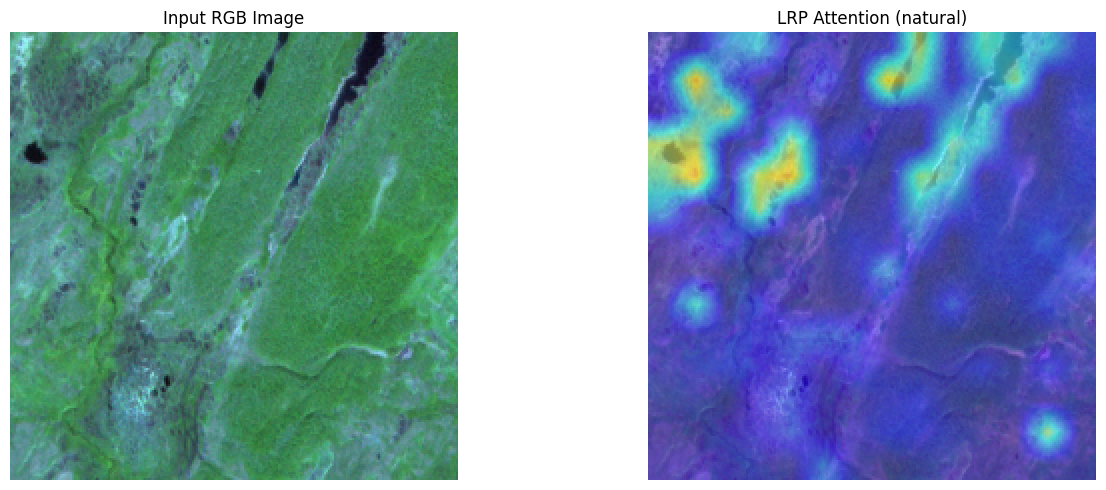

In [15]:
import torch
import matplotlib.pyplot as plt
import numpy as np
# 7. Restore thresholding flag
use_thresholding = False

# 1. Ensure thresholding is turned ON temporarily
prev_use_thresholding = use_thresholding if 'use_thresholding' in globals() else False
use_thresholding = False

# 2. Fetch and prepare the image
image_rgb, _ = train_dataset[0]  # Already preprocessed [3, 224, 224]

image_input = image_rgb.unsqueeze(0).to(device)  # Add batch dim
if image_input.dim() == 5:
    image_input = image_input.squeeze(2)

image_input.requires_grad_()  # Required for LRP

# 3. Forward pass (keep gradients ON for LRP)
model.eval()
output = model(image_input)

# 4. Prediction and attribution
predicted_class = output.argmax(dim=1).item()
print_top_classes(output)
# 5. Unnormalize image for visualization
def unnormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(-1, 1, 1)
    std = torch.tensor(std).view(-1, 1, 1)
    return tensor * std + mean



    
# Generate heatmaps
if image_rgb.dim() == 4 and image_rgb.shape[1] == 1:
    image_rgb = image_rgb.squeeze(1) 
heatmap_predicted = generate_visualization(image_rgb, class_index=predicted_class, use_thresholding=use_thresholding)
heatmap_other = generate_visualization(image_rgb, class_index=1 - predicted_class, use_thresholding=use_thresholding)



means_rgb = means[:3]  # Only the first 3 channels
stds_rgb = stds[:3]
image_rgb_unnorm = unnormalize(image_rgb.cpu(), means_rgb, stds_rgb)
image_np = image_rgb_unnorm.permute(1, 2, 0).numpy()
image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min() + 1e-5)

# 6. Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].imshow(image_np)
axs[0].set_title("Input RGB Image")
axs[0].axis('off')

axs[1].imshow(heatmap_predicted)
axs[1].set_title(f"LRP Attention ({CLS2IDX[predicted_class]})")
axs[1].axis('off')



plt.tight_layout()
plt.show()




### equip the vit-lrp with a decoder head to check uncertainty

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# --- Decoder head with dropout ---
class ReconstructionDecoder(nn.Module):
    def __init__(self, embed_dim=768, num_patches=196, patch_size=16, dropout_rate=0.1, in_chans=3):
        super().__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(embed_dim, patch_size * patch_size * in_chans)
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.in_chans = in_chans

    def forward(self, x):
        x = self.dropout(x)
        x = self.linear(x)  # [B, num_patches, patch_dim]
        B, N, D = x.shape
        x = x.view(B, int(N**0.5), int(N**0.5), self.in_chans, self.patch_size, self.patch_size)
        x = x.permute(0, 3, 1, 4, 2, 5).contiguous()
        x = x.view(B, self.in_chans, self.patch_size * int(N**0.5), self.patch_size * int(N**0.5))
        return x

# --- Combine ViT-LRP encoder with decoder head ---
class ViT_LRP_Reconstruction(nn.Module):
    def __init__(self, vit_lrp, decoder):
        super().__init__()
        self.encoder = vit_lrp
        self.decoder = decoder

    def forward(self, x):
        B = x.shape[0]
        tokens = self.encoder.patch_embed(x)
        cls_tokens = self.encoder.cls_token.expand(B, -1, -1)
        tokens = torch.cat((cls_tokens, tokens), dim=1)
        tokens = self.encoder.add([tokens, self.encoder.pos_embed])
        for blk in self.encoder.blocks:
            tokens = blk(tokens)
        encoded = self.encoder.norm(tokens[:, 1:, :])  # skip CLS token
        return self.decoder(encoded)

# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your pretrained ViT-LRP model
vit_lrp = vit_LRP(pretrained=False).to(device)  # Or pretrained=True
vit_lrp.head = nn.Identity()  # Remove classification head

decoder = ReconstructionDecoder(embed_dim=768, patch_size=16, in_chans=3).to(device)
model = ViT_LRP_Reconstruction(vit_lrp, decoder).to(device)

# --- Training config ---
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# --- Training loop ---
"""for epoch in range(1, 101):
    model.train()
    total_loss = 0.0
    for images, _ in tqdm(dataloader_train, desc=f"Epoch {epoch}"):
        if images.dim() == 5:
            images = images.squeeze(2)
        images = images.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)

    avg_loss = total_loss / len(dataloader_train.dataset)
    print(f"Epoch {epoch}: Reconstruction Loss = {avg_loss:.4f}")

    # ✅ Save model at epoch 10
    if epoch == 10:
        torch.save(model.state_dict(), "reconstruction_head.pth")
        print("🧠 Saved model checkpoint at epoch 10 → reconstruction_head.pth")
"""


'for epoch in range(1, 101):\n    model.train()\n    total_loss = 0.0\n    for images, _ in tqdm(dataloader_train, desc=f"Epoch {epoch}"):\n        if images.dim() == 5:\n            images = images.squeeze(2)\n        images = images.to(device)\n\n        optimizer.zero_grad()\n        outputs = model(images)\n        loss = criterion(outputs, images)\n        loss.backward()\n        optimizer.step()\n        total_loss += loss.item() * images.size(0)\n\n    avg_loss = total_loss / len(dataloader_train.dataset)\n    print(f"Epoch {epoch}: Reconstruction Loss = {avg_loss:.4f}")\n\n    # ✅ Save model at epoch 10\n    if epoch == 10:\n        torch.save(model.state_dict(), "reconstruction_head.pth")\n        print("🧠 Saved model checkpoint at epoch 10 → reconstruction_head.pth")\n'

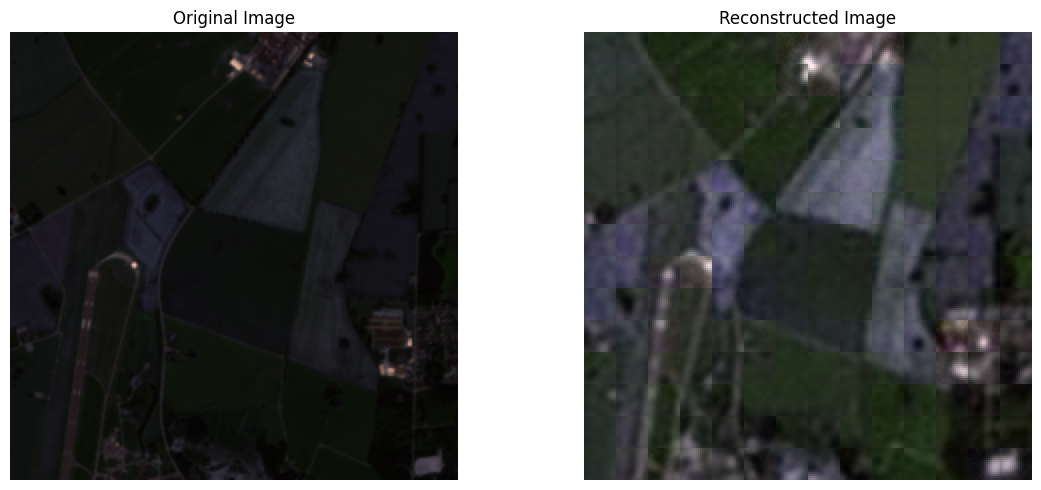

In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# === Define normalization helper ===
def normalize(img):
    return (img - img.min()) / (img.max() - img.min() + 1e-5)

# === Reload your model ===
vit_lrp = vit_LRP(pretrained=False)
vit_lrp.head = nn.Identity()

decoder = ReconstructionDecoder(embed_dim=768, patch_size=16, in_chans=3)
model = ViT_LRP_Reconstruction(vit_lrp, decoder)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("reconstruction_head.pth", map_location=device))
model = model.to(device).eval()

# === Get a single image from dataloader ===
images, _ = next(iter(dataloader_train))
if images.dim() == 5:
    images = images.squeeze(2)

images = images.to(device)
original = images[0].unsqueeze(0)  # Shape: [1, C, H, W]

# === Forward through model ===
reconstructed = model(original)

# === Prepare for plotting ===
original_np = original.squeeze(0).detach().cpu().numpy()
reconstructed_np = reconstructed.squeeze(0).detach().cpu().numpy()

# Normalize both for display
original_np = normalize(original_np)
reconstructed_np = normalize(reconstructed_np)

# === Plot ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].imshow(np.transpose(original_np, (1, 2, 0)))  # [H, W, C]
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(np.transpose(reconstructed_np, (1, 2, 0)))  # [H, W, C]
axs[1].set_title("Reconstructed Image")
axs[1].axis("off")

plt.tight_layout()
plt.show()


Input image shape: torch.Size([1, 3, 224, 224])
[0] output shape: torch.Size([1, 3, 224, 224])
[1] output shape: torch.Size([1, 3, 224, 224])
[2] output shape: torch.Size([1, 3, 224, 224])
[3] output shape: torch.Size([1, 3, 224, 224])
[4] output shape: torch.Size([1, 3, 224, 224])
[5] output shape: torch.Size([1, 3, 224, 224])
[6] output shape: torch.Size([1, 3, 224, 224])
[7] output shape: torch.Size([1, 3, 224, 224])
[8] output shape: torch.Size([1, 3, 224, 224])
[9] output shape: torch.Size([1, 3, 224, 224])
Stacked MC output shape: torch.Size([10, 1, 3, 224, 224])
MC outputs squeezed shape: torch.Size([10, 3, 224, 224])
STD over MC samples shape: torch.Size([3, 224, 224])
Final uncertainty map shape: torch.Size([224, 224])


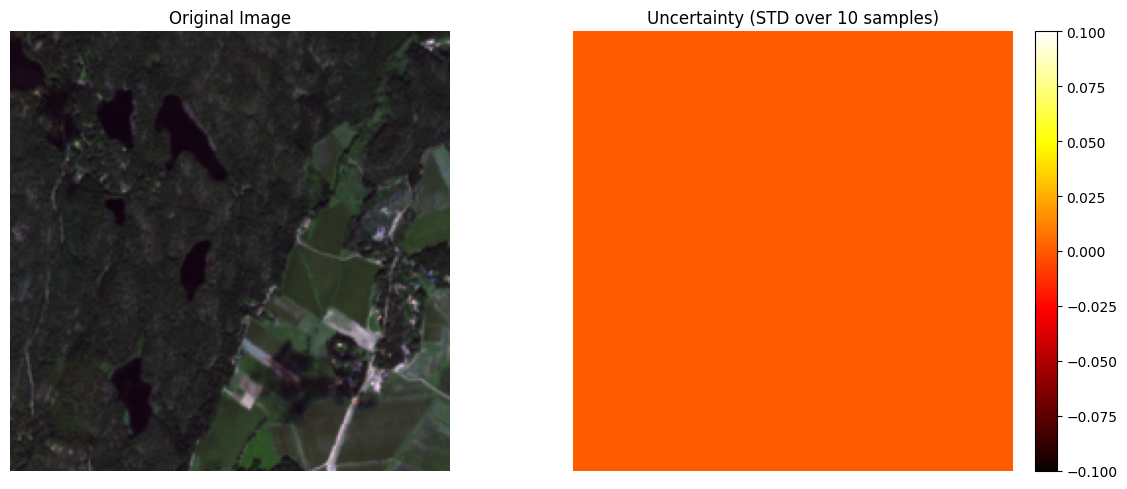

In [32]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

# --- Enable dropout during eval ---
def enable_dropout(model):
    for m in model.modules():
        if isinstance(m, nn.Dropout):
            m.train()

# --- Monte Carlo Dropout Forward Pass ---
def monte_carlo_dropout(model, input_image, num_samples=100):
    model.eval()
    enable_dropout(model)

    outputs = []
    for i in range(num_samples):
        output = model(input_image)  # Expected shape: [1, 3, 224, 224]
        print(f"[{i}] output shape:", output.shape)
        outputs.append(output.detach().cpu())

    stacked = torch.stack(outputs)  # [num_samples, 1, 3, 224, 224]?
    print("Stacked MC output shape:", stacked.shape)
    return stacked

# --- Normalize ---
def normalize(img):
    return (img - img.min()) / (img.max() - img.min() + 1e-5)

# --- Load one image from your dataloader ---
image, _ = next(iter(dataloader_train))
if image.dim() == 5:
    image = image.squeeze(2)
image = image[0].unsqueeze(0).to(device)  # [1, 3, 224, 224]
print("Input image shape:", image.shape)

# --- Run Monte Carlo Dropout ---
mc_outputs = monte_carlo_dropout(model, image, num_samples=10)

# Remove batch dim if present
if mc_outputs.dim() == 5:
    mc_outputs = mc_outputs.squeeze(1)  # [10, 3, H, W]
print("MC outputs squeezed shape:", mc_outputs.shape)

# --- Compute uncertainty ---
mc_std = torch.std(mc_outputs, dim=0)  # [3, H, W]
print("STD over MC samples shape:", mc_std.shape)

# --- Channel-wise mean ---
uncertainty_map = mc_std.mean(dim=0)  # [H, W]
print("Final uncertainty map shape:", uncertainty_map.shape)

# --- Visualize ---
original_np = image.squeeze(0).detach().cpu().numpy()  # [3, H, W]
original_np = normalize(original_np).transpose(1, 2, 0)  # [H, W, C]
uncertainty_map_np = normalize(uncertainty_map.cpu().numpy())  # [H, W]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(original_np)
axs[0].set_title("Original Image")
axs[0].axis("off")

im = axs[1].imshow(uncertainty_map_np, cmap='hot')
axs[1].set_title("Uncertainty (STD over 10 samples)")
axs[1].axis("off")

plt.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


### new reconstruction head with conv layer to make the reconstructed image smoother

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os

# --- CNN Decoder ---
class CNNDecoder(nn.Module):
    def __init__(self, embed_dim=768, patch_size=16, in_chans=3):
        super().__init__()
        self.patch_size = patch_size
        self.in_chans = in_chans
        self.linear = nn.Linear(embed_dim, patch_size * patch_size * in_chans)

        # CNN layers to smooth and upscale
        self.cnn = nn.Sequential(
            nn.Conv2d(in_chans, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, in_chans, kernel_size=3, padding=1),
        )

    def forward(self, x):
        B, N, D = x.shape
        x = self.linear(x)  # [B, N, patch_dim]
        h = w = int(N**0.5)
        x = x.view(B, h, w, self.in_chans, self.patch_size, self.patch_size)
        x = x.permute(0, 3, 1, 4, 2, 5).contiguous()
        x = x.view(B, self.in_chans, h * self.patch_size, w * self.patch_size)  # [B, 3, 224, 224]
        x = self.cnn(x)
        return x

# --- Model wrapper ---
class ViT_LRP_Reconstruction(nn.Module):
    def __init__(self, vit_lrp, decoder):
        super().__init__()
        self.encoder = vit_lrp
        self.decoder = decoder

    def forward(self, x):
        B = x.shape[0]
        tokens = self.encoder.patch_embed(x)
        cls_tokens = self.encoder.cls_token.expand(B, -1, -1)
        tokens = torch.cat((cls_tokens, tokens), dim=1)
        tokens = self.encoder.add([tokens, self.encoder.pos_embed])
        for blk in self.encoder.blocks:
            tokens = blk(tokens)
        encoded = self.encoder.norm(tokens[:, 1:, :])  # Exclude CLS token
        return self.decoder(encoded)

# --- Training setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# --- Load pre-trained ViT-LRP encoder ---
vit_lrp = vit_LRP(pretrained=False).to(device)
vit_lrp.head = nn.Identity()  # Remove classification head

# 🔁 Load your already trained weights here
state_dict = torch.load("./checkpoints_lrp_vit/vit_base_epoch10.pth", map_location=device)
vit_lrp.load_state_dict(state_dict, strict=False)
print("✅ Loaded pretrained ViT-LRP encoder weights (head ignored).")



decoder = CNNDecoder(embed_dim=768, patch_size=16, in_chans=3).to(device)
model = ViT_LRP_Reconstruction(vit_lrp, decoder).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# Training loop
for epoch in range(1, 101):
    model.train()
    total_loss = 0.0
    for images, _ in tqdm(dataloader_train, desc=f"Epoch {epoch}"):
        if images.dim() == 5:
            images = images.squeeze(2)
        images = images.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)

    avg_loss = total_loss / len(dataloader_train.dataset)
    print(f"Epoch {epoch}: Reconstruction Loss = {avg_loss:.4f}")

    if epoch % 10 == 0:
        model_path = f"vit_lrp_cnn_epoch{epoch}.pth"
        torch.save(model.state_dict(), model_path)
        print(f"🧠 Saved model checkpoint: {model_path}")


✅ Loaded pretrained ViT-LRP encoder weights (head ignored).


Epoch 1: 100%|██████████| 196/196 [00:09<00:00, 21.34it/s]


Epoch 1: Reconstruction Loss = 0.9391


Epoch 2: 100%|██████████| 196/196 [00:09<00:00, 21.17it/s]


Epoch 2: Reconstruction Loss = 0.6497


Epoch 3: 100%|██████████| 196/196 [00:09<00:00, 20.53it/s]


Epoch 3: Reconstruction Loss = 0.5156


Epoch 4: 100%|██████████| 196/196 [00:09<00:00, 21.04it/s]


Epoch 4: Reconstruction Loss = 0.5646


Epoch 5: 100%|██████████| 196/196 [00:08<00:00, 22.32it/s]


Epoch 5: Reconstruction Loss = 0.3953


Epoch 6: 100%|██████████| 196/196 [00:09<00:00, 21.57it/s]


Epoch 6: Reconstruction Loss = 0.3280


Epoch 7: 100%|██████████| 196/196 [00:09<00:00, 21.30it/s]


Epoch 7: Reconstruction Loss = 0.2854


Epoch 8: 100%|██████████| 196/196 [00:09<00:00, 21.52it/s]


Epoch 8: Reconstruction Loss = 0.2557


Epoch 9: 100%|██████████| 196/196 [00:09<00:00, 21.06it/s]


Epoch 9: Reconstruction Loss = 0.2268


Epoch 10: 100%|██████████| 196/196 [00:09<00:00, 21.47it/s]


Epoch 10: Reconstruction Loss = 0.1983
🧠 Saved model checkpoint: vit_lrp_cnn_epoch10.pth


Epoch 11: 100%|██████████| 196/196 [00:09<00:00, 21.74it/s]


Epoch 11: Reconstruction Loss = 0.1903


Epoch 12: 100%|██████████| 196/196 [00:09<00:00, 21.42it/s]


Epoch 12: Reconstruction Loss = 0.1774


Epoch 13: 100%|██████████| 196/196 [00:09<00:00, 21.31it/s]


Epoch 13: Reconstruction Loss = 0.1869


Epoch 14: 100%|██████████| 196/196 [00:09<00:00, 20.93it/s]


Epoch 14: Reconstruction Loss = 0.1719


Epoch 15: 100%|██████████| 196/196 [00:09<00:00, 21.15it/s]


Epoch 15: Reconstruction Loss = 0.1387


Epoch 16: 100%|██████████| 196/196 [00:09<00:00, 21.44it/s]


Epoch 16: Reconstruction Loss = 0.1431


Epoch 17: 100%|██████████| 196/196 [00:09<00:00, 21.57it/s]


Epoch 17: Reconstruction Loss = 0.1521


Epoch 18: 100%|██████████| 196/196 [00:09<00:00, 21.55it/s]


Epoch 18: Reconstruction Loss = 0.1311


Epoch 19: 100%|██████████| 196/196 [00:09<00:00, 21.22it/s]


Epoch 19: Reconstruction Loss = 0.1366


Epoch 20: 100%|██████████| 196/196 [00:09<00:00, 21.24it/s]


Epoch 20: Reconstruction Loss = 0.1064
🧠 Saved model checkpoint: vit_lrp_cnn_epoch20.pth


Epoch 21: 100%|██████████| 196/196 [00:09<00:00, 21.30it/s]


Epoch 21: Reconstruction Loss = 0.0985


Epoch 22: 100%|██████████| 196/196 [00:09<00:00, 20.46it/s]


Epoch 22: Reconstruction Loss = 0.0969


Epoch 23: 100%|██████████| 196/196 [00:09<00:00, 20.94it/s]


Epoch 23: Reconstruction Loss = 0.0932


Epoch 24: 100%|██████████| 196/196 [00:08<00:00, 22.29it/s]


Epoch 24: Reconstruction Loss = 0.0918


Epoch 25: 100%|██████████| 196/196 [00:08<00:00, 22.96it/s]


Epoch 25: Reconstruction Loss = 0.0935


Epoch 26: 100%|██████████| 196/196 [00:08<00:00, 21.95it/s]


Epoch 26: Reconstruction Loss = 0.0860


Epoch 27: 100%|██████████| 196/196 [00:08<00:00, 22.29it/s]


Epoch 27: Reconstruction Loss = 0.1105


Epoch 28: 100%|██████████| 196/196 [00:08<00:00, 21.97it/s]


Epoch 28: Reconstruction Loss = 0.1022


Epoch 29: 100%|██████████| 196/196 [00:09<00:00, 21.46it/s]


Epoch 29: Reconstruction Loss = 0.1139


Epoch 30: 100%|██████████| 196/196 [00:09<00:00, 20.78it/s]


Epoch 30: Reconstruction Loss = 0.0809
🧠 Saved model checkpoint: vit_lrp_cnn_epoch30.pth


Epoch 31: 100%|██████████| 196/196 [00:08<00:00, 22.26it/s]


Epoch 31: Reconstruction Loss = 0.0714


Epoch 32: 100%|██████████| 196/196 [00:08<00:00, 22.20it/s]


Epoch 32: Reconstruction Loss = 0.0696


Epoch 33: 100%|██████████| 196/196 [00:09<00:00, 21.09it/s]


Epoch 33: Reconstruction Loss = 0.0701


Epoch 34: 100%|██████████| 196/196 [00:08<00:00, 22.00it/s]


Epoch 34: Reconstruction Loss = 0.0731


Epoch 35: 100%|██████████| 196/196 [00:09<00:00, 21.72it/s]


Epoch 35: Reconstruction Loss = 0.0614


Epoch 36: 100%|██████████| 196/196 [00:08<00:00, 23.48it/s]


Epoch 36: Reconstruction Loss = 0.0624


Epoch 37: 100%|██████████| 196/196 [00:09<00:00, 21.75it/s]


Epoch 37: Reconstruction Loss = 0.0971


Epoch 38: 100%|██████████| 196/196 [00:08<00:00, 22.09it/s]


Epoch 38: Reconstruction Loss = 0.0698


Epoch 39: 100%|██████████| 196/196 [00:09<00:00, 20.86it/s]


Epoch 39: Reconstruction Loss = 0.0617


Epoch 40: 100%|██████████| 196/196 [00:09<00:00, 20.94it/s]


Epoch 40: Reconstruction Loss = 0.0583
🧠 Saved model checkpoint: vit_lrp_cnn_epoch40.pth


Epoch 41: 100%|██████████| 196/196 [00:09<00:00, 21.24it/s]


Epoch 41: Reconstruction Loss = 0.0623


Epoch 42: 100%|██████████| 196/196 [00:09<00:00, 20.88it/s]


Epoch 42: Reconstruction Loss = 0.0757


Epoch 43: 100%|██████████| 196/196 [00:09<00:00, 21.05it/s]


Epoch 43: Reconstruction Loss = 0.0595


Epoch 44: 100%|██████████| 196/196 [00:09<00:00, 21.44it/s]


Epoch 44: Reconstruction Loss = 0.0613


Epoch 45: 100%|██████████| 196/196 [00:09<00:00, 20.70it/s]


Epoch 45: Reconstruction Loss = 0.0486


Epoch 46: 100%|██████████| 196/196 [00:09<00:00, 21.72it/s]


Epoch 46: Reconstruction Loss = 0.0505


Epoch 47: 100%|██████████| 196/196 [00:09<00:00, 21.41it/s]


Epoch 47: Reconstruction Loss = 0.0451


Epoch 48: 100%|██████████| 196/196 [00:09<00:00, 21.54it/s]


Epoch 48: Reconstruction Loss = 0.0505


Epoch 49: 100%|██████████| 196/196 [00:09<00:00, 21.28it/s]


Epoch 49: Reconstruction Loss = 0.0593


Epoch 50: 100%|██████████| 196/196 [00:09<00:00, 21.51it/s]


Epoch 50: Reconstruction Loss = 0.0488
🧠 Saved model checkpoint: vit_lrp_cnn_epoch50.pth


Epoch 51: 100%|██████████| 196/196 [00:09<00:00, 21.59it/s]


Epoch 51: Reconstruction Loss = 0.0470


Epoch 52: 100%|██████████| 196/196 [00:09<00:00, 21.43it/s]


Epoch 52: Reconstruction Loss = 0.0601


Epoch 53: 100%|██████████| 196/196 [00:09<00:00, 21.19it/s]


Epoch 53: Reconstruction Loss = 0.0505


Epoch 54: 100%|██████████| 196/196 [00:09<00:00, 20.95it/s]


Epoch 54: Reconstruction Loss = 0.0448


Epoch 55: 100%|██████████| 196/196 [00:09<00:00, 21.05it/s]


Epoch 55: Reconstruction Loss = 0.0423


Epoch 56: 100%|██████████| 196/196 [00:09<00:00, 21.25it/s]


Epoch 56: Reconstruction Loss = 0.0423


Epoch 57: 100%|██████████| 196/196 [00:09<00:00, 21.19it/s]


Epoch 57: Reconstruction Loss = 0.0398


Epoch 58: 100%|██████████| 196/196 [00:09<00:00, 21.16it/s]


Epoch 58: Reconstruction Loss = 0.0491


Epoch 59: 100%|██████████| 196/196 [00:09<00:00, 21.05it/s]


Epoch 59: Reconstruction Loss = 0.0493


Epoch 60: 100%|██████████| 196/196 [00:09<00:00, 20.54it/s]


Epoch 60: Reconstruction Loss = 0.0455
🧠 Saved model checkpoint: vit_lrp_cnn_epoch60.pth


Epoch 61: 100%|██████████| 196/196 [00:09<00:00, 20.79it/s]


Epoch 61: Reconstruction Loss = 0.0433


Epoch 62: 100%|██████████| 196/196 [00:09<00:00, 21.53it/s]


Epoch 62: Reconstruction Loss = 0.0466


Epoch 63: 100%|██████████| 196/196 [00:09<00:00, 21.64it/s]


Epoch 63: Reconstruction Loss = 0.0383


Epoch 64: 100%|██████████| 196/196 [00:09<00:00, 21.50it/s]


Epoch 64: Reconstruction Loss = 0.0399


Epoch 65: 100%|██████████| 196/196 [00:08<00:00, 22.34it/s]


Epoch 65: Reconstruction Loss = 0.0443


Epoch 66: 100%|██████████| 196/196 [00:09<00:00, 21.20it/s]


Epoch 66: Reconstruction Loss = 0.0592


Epoch 67: 100%|██████████| 196/196 [00:09<00:00, 21.14it/s]


Epoch 67: Reconstruction Loss = 0.0466


Epoch 68: 100%|██████████| 196/196 [00:09<00:00, 21.27it/s]


Epoch 68: Reconstruction Loss = 0.0384


Epoch 69: 100%|██████████| 196/196 [00:09<00:00, 21.32it/s]


Epoch 69: Reconstruction Loss = 0.0363


Epoch 70: 100%|██████████| 196/196 [00:09<00:00, 21.14it/s]


Epoch 70: Reconstruction Loss = 0.0337
🧠 Saved model checkpoint: vit_lrp_cnn_epoch70.pth


Epoch 71: 100%|██████████| 196/196 [00:09<00:00, 20.93it/s]


Epoch 71: Reconstruction Loss = 0.0338


Epoch 72: 100%|██████████| 196/196 [00:09<00:00, 21.18it/s]


Epoch 72: Reconstruction Loss = 0.0381


Epoch 73: 100%|██████████| 196/196 [00:09<00:00, 21.59it/s]


Epoch 73: Reconstruction Loss = 0.0456


Epoch 74: 100%|██████████| 196/196 [00:09<00:00, 21.37it/s]


Epoch 74: Reconstruction Loss = 0.0365


Epoch 75: 100%|██████████| 196/196 [00:09<00:00, 21.25it/s]


Epoch 75: Reconstruction Loss = 0.0386


Epoch 76: 100%|██████████| 196/196 [00:09<00:00, 21.53it/s]


Epoch 76: Reconstruction Loss = 0.0420


Epoch 77: 100%|██████████| 196/196 [00:09<00:00, 21.65it/s]


Epoch 77: Reconstruction Loss = 0.0396


Epoch 78: 100%|██████████| 196/196 [00:09<00:00, 21.18it/s]


Epoch 78: Reconstruction Loss = 0.0362


Epoch 79: 100%|██████████| 196/196 [00:09<00:00, 21.02it/s]


Epoch 79: Reconstruction Loss = 0.0349


Epoch 80: 100%|██████████| 196/196 [00:09<00:00, 20.67it/s]


Epoch 80: Reconstruction Loss = 0.0374
🧠 Saved model checkpoint: vit_lrp_cnn_epoch80.pth


Epoch 81: 100%|██████████| 196/196 [00:09<00:00, 21.08it/s]


Epoch 81: Reconstruction Loss = 0.0332


Epoch 82: 100%|██████████| 196/196 [00:09<00:00, 21.34it/s]


Epoch 82: Reconstruction Loss = 0.0334


Epoch 83: 100%|██████████| 196/196 [00:09<00:00, 21.74it/s]


Epoch 83: Reconstruction Loss = 0.0329


Epoch 84: 100%|██████████| 196/196 [00:09<00:00, 20.60it/s]


Epoch 84: Reconstruction Loss = 0.0326


Epoch 85: 100%|██████████| 196/196 [00:08<00:00, 22.16it/s]


Epoch 85: Reconstruction Loss = 0.0391


Epoch 86: 100%|██████████| 196/196 [00:08<00:00, 22.13it/s]


Epoch 86: Reconstruction Loss = 0.0350


Epoch 87: 100%|██████████| 196/196 [00:09<00:00, 21.49it/s]


Epoch 87: Reconstruction Loss = 0.0349


Epoch 88: 100%|██████████| 196/196 [00:08<00:00, 21.81it/s]


Epoch 88: Reconstruction Loss = 0.0331


Epoch 89: 100%|██████████| 196/196 [00:09<00:00, 21.45it/s]


Epoch 89: Reconstruction Loss = 0.0481


Epoch 90: 100%|██████████| 196/196 [00:09<00:00, 20.87it/s]


Epoch 90: Reconstruction Loss = 0.0538
🧠 Saved model checkpoint: vit_lrp_cnn_epoch90.pth


Epoch 91: 100%|██████████| 196/196 [00:09<00:00, 21.70it/s]


Epoch 91: Reconstruction Loss = 0.0300


Epoch 92: 100%|██████████| 196/196 [00:09<00:00, 21.63it/s]


Epoch 92: Reconstruction Loss = 0.0299


Epoch 93: 100%|██████████| 196/196 [00:09<00:00, 21.19it/s]


Epoch 93: Reconstruction Loss = 0.0293


Epoch 94: 100%|██████████| 196/196 [00:09<00:00, 21.72it/s]


Epoch 94: Reconstruction Loss = 0.0280


Epoch 95: 100%|██████████| 196/196 [00:09<00:00, 21.69it/s]


Epoch 95: Reconstruction Loss = 0.0273


Epoch 96: 100%|██████████| 196/196 [00:09<00:00, 21.72it/s]


Epoch 96: Reconstruction Loss = 0.0272


Epoch 97: 100%|██████████| 196/196 [00:09<00:00, 21.08it/s]


Epoch 97: Reconstruction Loss = 0.0272


Epoch 98: 100%|██████████| 196/196 [00:09<00:00, 21.59it/s]


Epoch 98: Reconstruction Loss = 0.0337


Epoch 99: 100%|██████████| 196/196 [00:09<00:00, 21.60it/s]


Epoch 99: Reconstruction Loss = 0.0335


Epoch 100: 100%|██████████| 196/196 [00:09<00:00, 21.61it/s]


Epoch 100: Reconstruction Loss = 0.0343
🧠 Saved model checkpoint: vit_lrp_cnn_epoch100.pth


### load the reconstruction head and plot


✅ Model loaded.


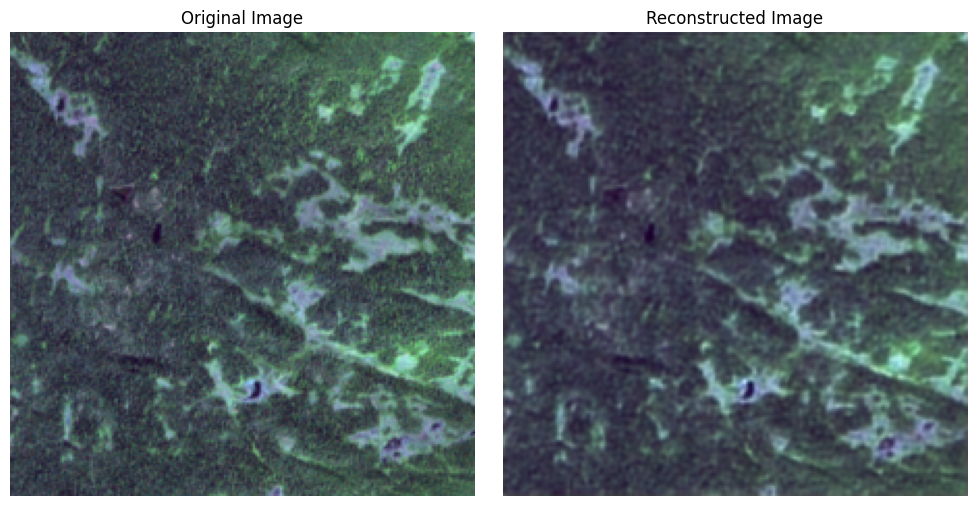

In [37]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# --- Helper: Normalize for plotting ---
def normalize(img):
    return (img - img.min()) / (img.max() - img.min() + 1e-5)

# --- Reload model architecture ---
vit_lrp = vit_LRP(pretrained=False)
vit_lrp.head = nn.Identity()

# CNN Decoder (same as training)
class CNNDecoder(nn.Module):
    def __init__(self, embed_dim=768, patch_size=16, in_chans=3):
        super().__init__()
        self.patch_size = patch_size
        self.in_chans = in_chans
        self.linear = nn.Linear(embed_dim, patch_size * patch_size * in_chans)

        # CNN layers to smooth and upscale
        self.cnn = nn.Sequential(
            nn.Conv2d(in_chans, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, in_chans, kernel_size=3, padding=1),
        )

    def forward(self, x):
        B, N, D = x.shape
        x = self.linear(x)  # [B, N, patch_dim]
        h = w = int(N**0.5)
        x = x.view(B, h, w, self.in_chans, self.patch_size, self.patch_size)
        x = x.permute(0, 3, 1, 4, 2, 5).contiguous()
        x = x.view(B, self.in_chans, h * self.patch_size, w * self.patch_size)  # [B, 3, 224, 224]
        x = self.cnn(x)
        return x

class ViT_LRP_Reconstruction(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        B = x.shape[0]
        tokens = self.encoder.patch_embed(x)
        cls_tokens = self.encoder.cls_token.expand(B, -1, -1)
        tokens = torch.cat((cls_tokens, tokens), dim=1)
        tokens = self.encoder.add([tokens, self.encoder.pos_embed])
        for blk in self.encoder.blocks:
            tokens = blk(tokens)
        encoded = self.encoder.norm(tokens[:, 1:, :])
        return self.decoder(encoded)

# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_lrp = vit_lrp.to(device)
decoder = CNNDecoder().to(device)
model = ViT_LRP_Reconstruction(vit_lrp, decoder).to(device)

# --- Load weights ---
model.load_state_dict(torch.load("vit_lrp_cnn_epoch100.pth", map_location=device))
model.eval()
print("✅ Model loaded.")

# --- Get one image from dataset ---
images, _ = next(iter(dataloader_train))
if images.dim() == 5:
    images = images.squeeze(2)

original = images[0].unsqueeze(0).to(device)

# --- Forward pass ---

reconstructed = model(original)

# --- Convert for plotting ---
original_np = normalize(original.squeeze(0).cpu().numpy()).transpose(1, 2, 0)
reconstructed_np = normalize(reconstructed.squeeze(0).detach().cpu().numpy()).transpose(1, 2, 0)

# --- Plot ---
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(original_np)
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(reconstructed_np)
axs[1].set_title("Reconstructed Image")
axs[1].axis("off")

plt.tight_layout()
plt.show()



MC outputs shape: (100, 1, 3, 224, 224)
STD shape: (1, 3, 224, 224)
Final uncertainty map shape: (224, 224)


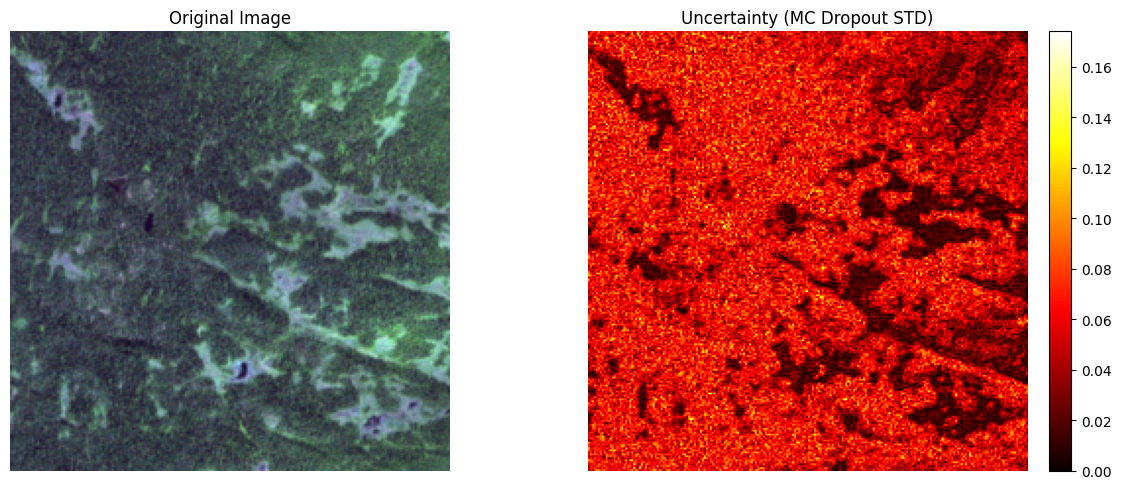

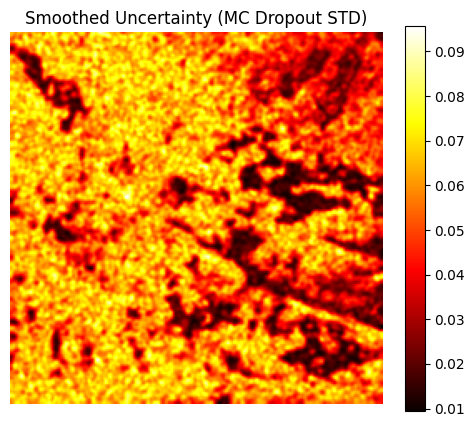

In [43]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# --- Normalize for plotting ---
def normalize(img):
    return (img - img.min()) / (img.max() - img.min() + 1e-5)

# --- Enable dropout during eval ---
def enable_dropout(model):
    for m in model.modules():
        if isinstance(m, torch.nn.Dropout):
            m.train()

# --- Run Monte Carlo Dropout ---
def monte_carlo_dropout(model, input_image, num_samples=100):
    model.eval()
    enable_dropout(model)
    outputs = []
    for _ in range(num_samples):
        out = model(input_image)
        outputs.append(out.detach().cpu().numpy())
    outputs = np.stack(outputs, axis=0)  # [num_samples, C, H, W]
    return outputs

# === Run MC Dropout ===
mc_outputs = monte_carlo_dropout(model, original, num_samples=100)  # [100, C, H, W]
print("MC outputs shape:", mc_outputs.shape)

# === Compute Uncertainty Map ===
mc_std = np.std(mc_outputs, axis=0)  # [1, 3, 224, 224]
print("STD shape:", mc_std.shape)

uncertainty_map = mc_std.squeeze(0).mean(axis=0)  # ✅ [224, 224]
print("Final uncertainty map shape:", uncertainty_map.shape)

uncertainty_map = normalize(uncertainty_map)

# === Original image prep ===
original_np = normalize(original.squeeze(0).detach().cpu().numpy()).transpose(1, 2, 0)  # [H, W, C]

# === Plot original and uncertainty ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].imshow(original_np)
axs[0].set_title("Original Image")
axs[0].axis("off")

im = axs[1].imshow(uncertainty_map, cmap="hot")  # Now definitely [H, W]
axs[1].set_title("Uncertainty (MC Dropout STD)")
axs[1].axis("off")

plt.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

import cv2

# Apply Gaussian blur (you can tune kernel size and sigma)
uncertainty_map_smoothed = cv2.GaussianBlur(uncertainty_map, (5, 5), sigmaX=1)

# Re-plot
plt.figure(figsize=(6, 5))
plt.imshow(uncertainty_map_smoothed, cmap="hot")
plt.title("Smoothed Uncertainty (MC Dropout STD)")
plt.axis("off")
plt.colorbar()
plt.show()



### compare mc to pixel entropy

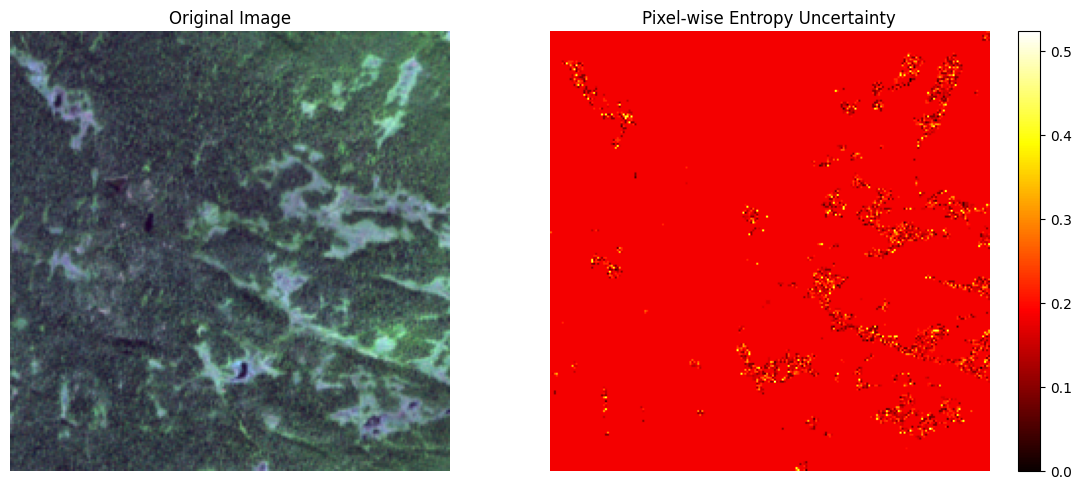

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
import torch

# --- Helper to enable dropout ---
def enable_dropout(model):
    for m in model.modules():
        if isinstance(m, torch.nn.Dropout):
            m.train()

# --- Run MC dropout ---
def run_monte_carlo(model, input_tensor, num_samples=100):
    model.eval()
    enable_dropout(model)
    preds = []

    for _ in range(num_samples):
        out = model(input_tensor)  # [1, C, H, W]
        preds.append(out.detach().cpu().numpy())

    return np.stack(preds)  # [N, 1, C, H, W]

# --- Compute pixel-wise entropy ---
def compute_pixel_entropy(mc_outputs):
    mc_outputs = mc_outputs.squeeze(1)  # [N, C, H, W]
    mc_outputs = np.clip(mc_outputs, 1e-8, None)
    mc_outputs = mc_outputs / mc_outputs.sum(axis=1, keepdims=True)  # normalize across channels

    # Entropy across samples for each pixel
    mc_outputs = mc_outputs.transpose(1, 2, 3, 0)  # [C, H, W, N]
    entropies = entropy(mc_outputs, axis=-1)      # [C, H, W]
    return entropies.mean(axis=0)                 # [H, W]

# --- Run it on one image ---
image_tensor = original  # already [1, 3, 224, 224] on device

mc_outputs = run_monte_carlo(model, image_tensor, num_samples=100)
pixel_entropy = compute_pixel_entropy(mc_outputs)

# Normalize
pixel_entropy = (pixel_entropy - pixel_entropy.min()) / (pixel_entropy.max() - pixel_entropy.min() + 1e-5)

# Visualize
original_np = original.squeeze(0).detach().cpu().numpy()
original_np = (original_np - original_np.min()) / (original_np.max() - original_np.min() + 1e-5)
original_np = original_np.transpose(1, 2, 0)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_np)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(pixel_entropy, cmap="hot")
plt.title("Pixel-wise Entropy Uncertainty")
plt.axis("off")
plt.colorbar()
plt.tight_layout()
plt.show()


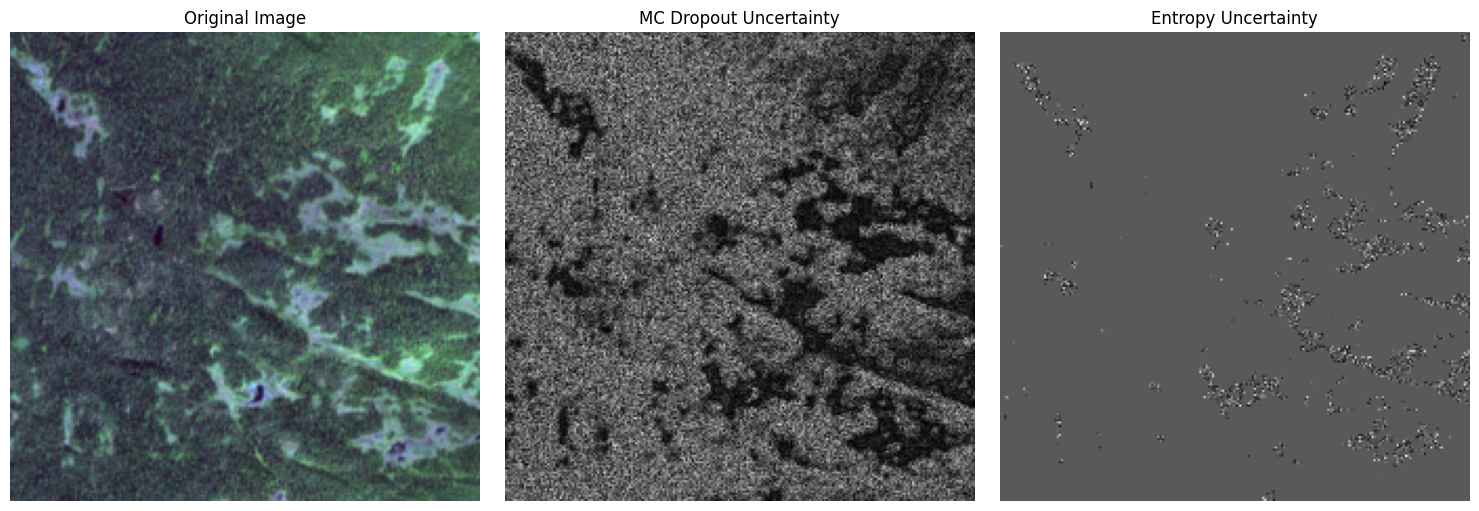

In [48]:
import matplotlib.pyplot as plt
import numpy as np

def normalize(img):
    img = img - np.min(img)
    return img / (np.max(img) + 1e-5)

# --- Ensure shapes ---
if original_np.shape[0] == 3:
    original_vis = original_np.transpose(1, 2, 0)
else:
    original_vis = original_np

# --- Make sure MC and entropy maps are 2D ---
if mc_std_vis.shape == (3, 224, 224):
    mc_std_vis = mc_std_vis.mean(axis=0)
if pixel_entropy.shape == (3, 224, 224):
    entropy_vis = pixel_entropy.mean(axis=0)
else:
    entropy_vis = pixel_entropy

# --- Normalize all ---
original_vis = normalize(original_vis)
mc_std_vis = normalize(mc_std_vis)
entropy_vis = normalize(entropy_vis)

# --- Plot ---
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(original_vis)
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(mc_std_vis, cmap="gray")
axs[1].set_title("MC Dropout Uncertainty")
axs[1].axis("off")

axs[2].imshow(entropy_vis, cmap="gray")
axs[2].set_title("Entropy Uncertainty")
axs[2].axis("off")

plt.tight_layout()
plt.show()


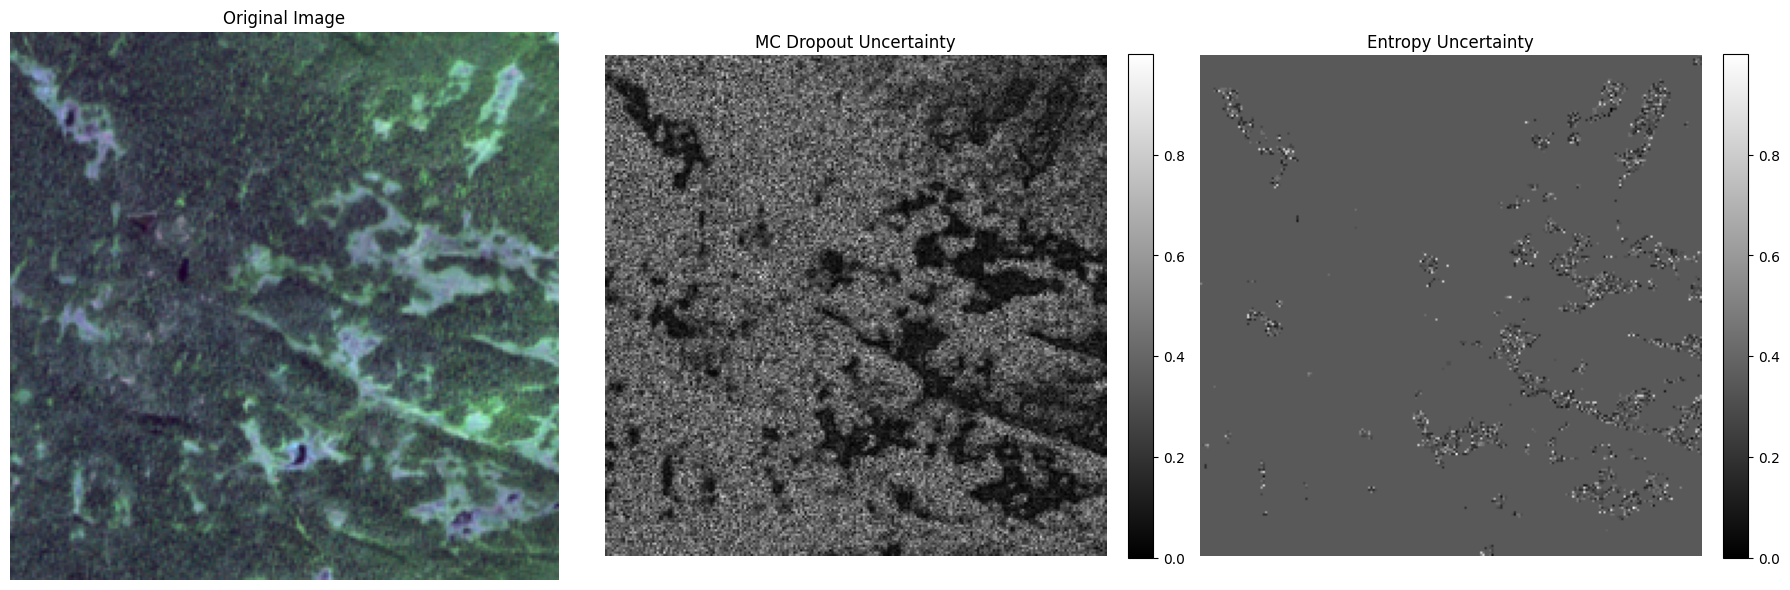

In [49]:
import matplotlib.pyplot as plt
import numpy as np

def normalize(img):
    img = img - np.min(img)
    return img / (np.max(img) + 1e-5)

# --- Ensure shapes ---
if original_np.shape[0] == 3:
    original_vis = original_np.transpose(1, 2, 0)
else:
    original_vis = original_np

if mc_std_vis.shape == (3, 224, 224):
    mc_std_vis = mc_std_vis.mean(axis=0)

if pixel_entropy.shape == (3, 224, 224):
    entropy_vis = pixel_entropy.mean(axis=0)
else:
    entropy_vis = pixel_entropy

# --- Normalize ---
original_vis = normalize(original_vis)
mc_std_vis = normalize(mc_std_vis)
entropy_vis = normalize(entropy_vis)

# --- Plot with colorbars ---
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].imshow(original_vis)
axs[0].set_title("Original Image")
axs[0].axis("off")

im1 = axs[1].imshow(mc_std_vis, cmap="gray")
axs[1].set_title("MC Dropout Uncertainty")
axs[1].axis("off")
plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

im2 = axs[2].imshow(entropy_vis, cmap="gray")
axs[2].set_title("Entropy Uncertainty")
axs[2].axis("off")
plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()
